# Visualization
**Prof. Bernhard Schmitzer, Uni Göttingen**
**Summer Term 2025**

## Problem Sheet 8

- **Submission deadline**: 2025-07-09, 18:00 via StudIP as a single PDF or ZIP.
  Combine all results into **one** file. If you work in Markdown or Jupyter notebooks, include a converted PDF version.
- Use **Python 3** for programming tasks as demonstrated in the lecture.
  If you cannot install Python locally, consider using the [GWDG Jupyter server](https://jupyter-cloud.gwdg.de/).
  Your submission must include **both** the final images and the source code used to generate them.
- You may work in **groups of up to three**. Clearly state **names** and **enrollment numbers** at the start of your submission.

---

## Exercise 8.1: Flow Matching

Let
\[
\mu : [0,1]^2 \rightarrow \mathbb{R}
\]
be the probability density function describing a **uniform measure** over the rectangle \[[0.05, 0.65] × [0.05, 0.95]\].

Let
\[
\nu
\]
be the analogous uniform density on \[[0.35, 0.95] × [0.05, 0.95]\].

This task investigates the **flow matching** technique as introduced in:

- Lipman et al., *Flow Matching for Generative Modeling*, ICLR 2023
- Liu et al., *Flow Straight and Fast: Learning to Generate and Transfer Data with Rectified Flow*, ICLR 2023

> A deep understanding of these papers is not required, but a rough idea is helpful, pissina.

The provided file `flows.npz` contains samples from three stochastic interpolations between μ and ν. It includes:

- `t = np.linspace(0,1,nT)` with `nT = 51`: evaluation times.
- `xA`, `xB`, `xC`: arrays of shape `(nT, nX, 2)` with `nX = 5000` representing:
  - `xA`: straight-line interpolation (independent coupling of μ and ν)
  - `xB`: flow field-based interpolation (via flow matching)
  - `xC`: straight-line re-interpolation of start/end points from `xB`

**Notation**:
For `x ∈ {xA, xB, xC}`, the array entry `x[i,j,k]` represents the `k`-th coordinate of the `j`-th particle at time `t[i]`.
- `x[0,:,:]`: samples from μ
- `x[-1,:,:]`: approximately samples from ν

---

### Tasks

1. **Trajectory Visualization**
   Visualize trajectories of a representative subset of particles from all three interpolations {xA, xB, xC}.
   Make sure the distinction between:
   - ‘mixed’ straight lines (xA)
   - curved flows (xB)
   - ‘aligned’ straight lines (xC)
   is clearly visible.

2. **Dynamic Particle Visualization**
   Create dynamic visualizations to illustrate how individual particles move over time.
   The qualitative differences in motion between the three methods should be clearly observable.

3. **Dynamic Density Visualization**
   For selected indices `nt ∈ {0, ..., nT−1}`, estimate and visualize the **2D probability density** of particles `x[nt,:,:]` on \[[0, 1]^2\] using histograms or KDE.
   Show the evolution of these densities over time.
   - Identify which two distributions are approximately equal.

> **Hint**: Use a Jupyter notebook for this problem. Dynamic elements cannot be shown in PDF.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
flows = np.load('flows.npz')
t = flows['t']
flowA = flows['xA']
flowB = flows['xB']
flowC = flows['xC']

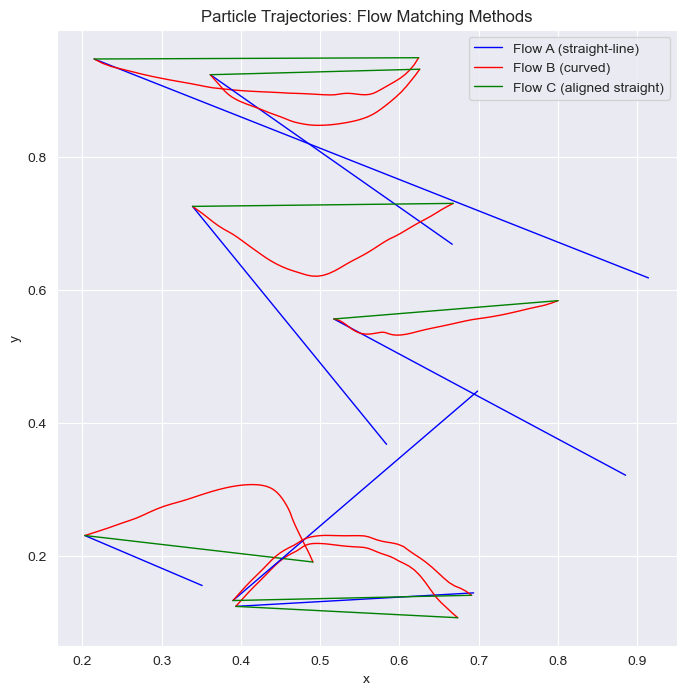

In [3]:
ax = plt.figure(figsize=(8,8))
for i in range(10,17):
    if i == 10:
        plt.plot(flowA[:,i,0],flowA[:,i,1],'b-',linewidth=1, label='Flow A (straight-line)')
        plt.plot(flowB[:,i,0],flowB[:,i,1],'r-',linewidth=1, label='Flow B (curved)')
        plt.plot(flowC[:,i,0],flowC[:,i,1],'g-',linewidth=1, label='Flow C (aligned straight)')
    else:
        plt.plot(flowA[:,i,0],flowA[:,i,1],'b-',linewidth=1)
        plt.plot(flowB[:,i,0],flowB[:,i,1],'r-',linewidth=1)
        plt.plot(flowC[:,i,0],flowC[:,i,1],'g-',linewidth=1)

plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Particle Trajectories: Flow Matching Methods')
plt.show()


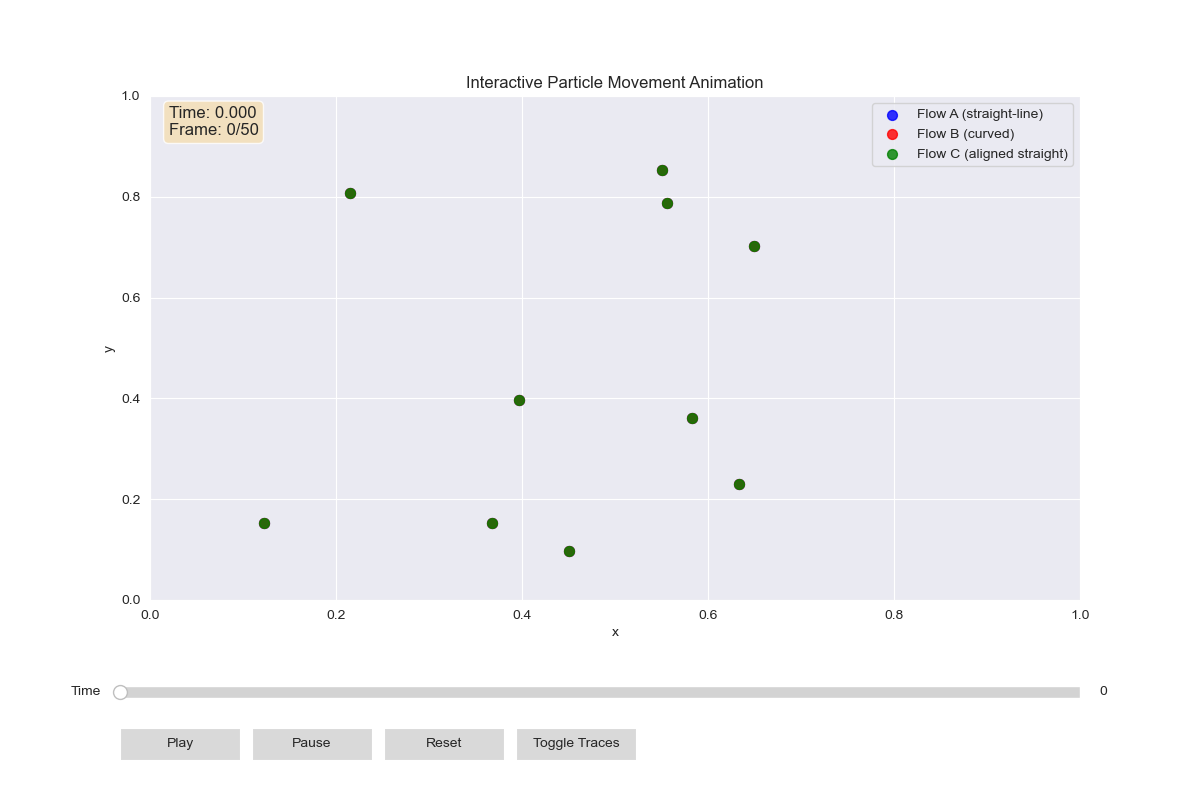

In [4]:
%matplotlib widget
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.widgets import Button, Slider
import matplotlib.patches as patches

n_particles = 10
particle_indices = np.random.choice(flowA.shape[1], n_particles, replace=False)

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 8))
plt.subplots_adjust(bottom=0.25)

# Initialize scatter plots and trace lines
scatter_A = ax.scatter([], [], c='blue', label='Flow A (straight-line)', alpha=0.8, s=50)
scatter_B = ax.scatter([], [], c='red', label='Flow B (curved)', alpha=0.8, s=50)
scatter_C = ax.scatter([], [], c='green', label='Flow C (aligned straight)', alpha=0.8, s=50)

# Initialize trace lines
trace_A = [ax.plot([], [], 'b-', alpha=0.3, linewidth=1)[0] for _ in range(n_particles)]
trace_B = [ax.plot([], [], 'r-', alpha=0.3, linewidth=1)[0] for _ in range(n_particles)]
trace_C = [ax.plot([], [], 'g-', alpha=0.3, linewidth=1)[0] for _ in range(n_particles)]

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.legend()
ax.set_title('Interactive Particle Movement Animation')
ax.set_xlabel('x')
ax.set_ylabel('y')

# Animation state
class AnimationState:
    def __init__(self):
        self.current_frame = 0
        self.is_playing = False
        self.show_traces = True
        self.trace_length = 30
        self.updating_slider = False  # Flag to prevent recursion

state = AnimationState()

# Create buttons
ax_play = plt.axes([0.1, 0.05, 0.1, 0.04])
ax_pause = plt.axes([0.21, 0.05, 0.1, 0.04])
ax_reset = plt.axes([0.32, 0.05, 0.1, 0.04])
ax_traces = plt.axes([0.43, 0.05, 0.1, 0.04])

btn_play = Button(ax_play, 'Play')
btn_pause = Button(ax_pause, 'Pause')
btn_reset = Button(ax_reset, 'Reset')
btn_traces = Button(ax_traces, 'Toggle Traces')

# Create slider for time navigation
ax_slider = plt.axes([0.1, 0.12, 0.8, 0.03])
slider_time = Slider(ax_slider, 'Time', 0, len(t)-1, valinit=0, valfmt='%d')

# Time display
time_text = ax.text(0.02, 0.98, '', transform=ax.transAxes, fontsize=12,
                   verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

def update_plot(frame, update_slider=True):
    # Update current positions
    scatter_A.set_offsets(flowA[frame, particle_indices])
    scatter_B.set_offsets(flowB[frame, particle_indices])
    scatter_C.set_offsets(flowC[frame, particle_indices])

    # Update traces if enabled
    if state.show_traces:
        trace_start = max(0, frame - state.trace_length)
        for i in range(n_particles):
            particle_idx = particle_indices[i]

            # Update trace for Flow A
            trace_A[i].set_data(flowA[trace_start:frame+1, particle_idx, 0],
                               flowA[trace_start:frame+1, particle_idx, 1])

            # Update trace for Flow B
            trace_B[i].set_data(flowB[trace_start:frame+1, particle_idx, 0],
                               flowB[trace_start:frame+1, particle_idx, 1])

            # Update trace for Flow C
            trace_C[i].set_data(flowC[trace_start:frame+1, particle_idx, 0],
                               flowC[trace_start:frame+1, particle_idx, 1])
    else:
        # Clear traces
        for i in range(n_particles):
            trace_A[i].set_data([], [])
            trace_B[i].set_data([], [])
            trace_C[i].set_data([], [])

    # Update time display
    time_text.set_text(f'Time: {t[frame]:.3f}\nFrame: {frame}/{len(t)-1}')

    if update_slider and not state.updating_slider:
        state.updating_slider = True
        slider_time.set_val(frame)
        state.updating_slider = False

def animate(frame):
    if state.is_playing:
        state.current_frame = (state.current_frame + 1) % len(t)
        update_plot(state.current_frame)
    return [scatter_A, scatter_B, scatter_C] + trace_A + trace_B + trace_C

def play_callback(event):
    state.is_playing = True

def pause_callback(event):
    state.is_playing = False

def reset_callback(event):
    state.current_frame = 0
    state.is_playing = False
    update_plot(0)

def toggle_traces_callback(event):
    state.show_traces = not state.show_traces
    update_plot(state.current_frame)

def slider_callback(val):
    if not state.updating_slider:
        state.current_frame = int(val)
        state.is_playing = False
        update_plot(state.current_frame, update_slider=False)

# Connect callbacks
btn_play.on_clicked(play_callback)
btn_pause.on_clicked(pause_callback)
btn_reset.on_clicked(reset_callback)
btn_traces.on_clicked(toggle_traces_callback)
slider_time.on_changed(slider_callback)



# Create animation
anim = FuncAnimation(fig, animate, frames=len(t), interval=100, blit=False, repeat=True)

# Initial plot
update_plot(0)


plt.show()

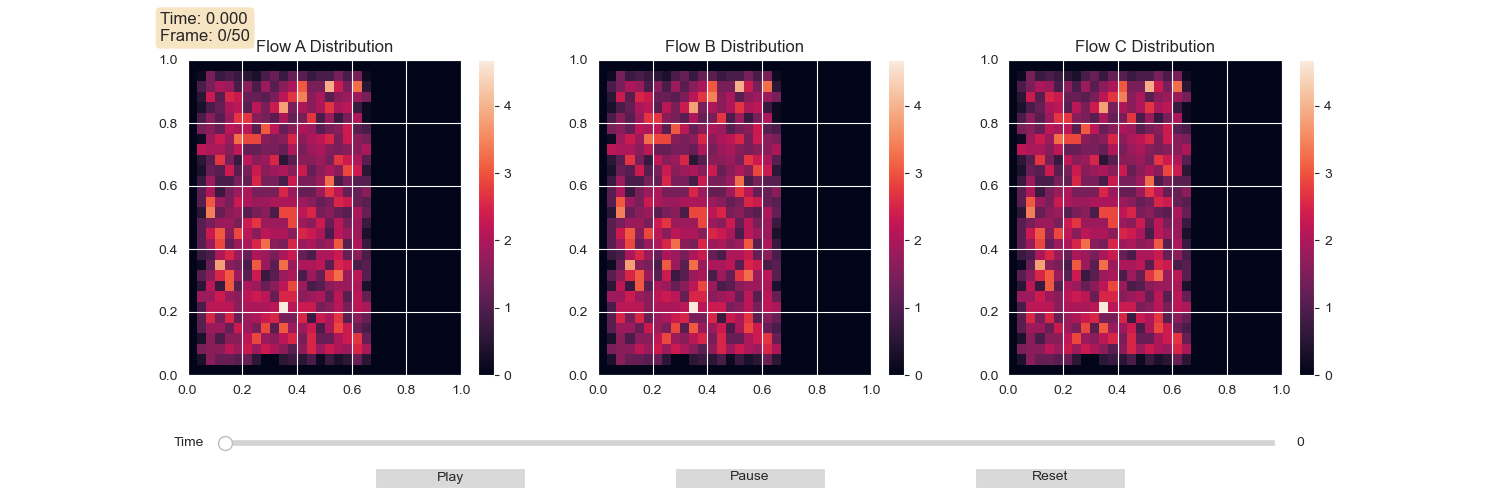

In [8]:
%matplotlib widget
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.widgets import Button, Slider

# --- Helper function to set up each subplot ---
def setup_histogram_subplot(ax, flow_data, title):
    """Initializes a 2D histogram subplot."""
    H, xedges, yedges = np.histogram2d(flow_data[0, :, 0], flow_data[0, :, 1], bins=30, range=[[0, 1], [0, 1]], density=True)
    im = ax.imshow(H.T, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='auto', interpolation='nearest')
    ax.set_title(title)
    fig.colorbar(im, ax=ax)
    return im

# --- Helper function to update each histogram ---
def update_histogram(im, flow_data, frame):
    """Updates the data of a single histogram image."""
    H, _, _ = np.histogram2d(flow_data[frame, :, 0], flow_data[frame, :, 1], bins=30, range=[[0, 1], [0, 1]], density=True)
    im.set_data(H.T)
    vmin, vmax = H.min(), H.max()
    if vmin == vmax:
        vmin, vmax = vmin - 1, vmax + 1
    im.set_clim(vmin=vmin, vmax=vmax)

# --- Main Setup ---
# Create figure with 3 subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
plt.subplots_adjust(bottom=0.25)

# Initialize the three histogram plots
im1 = setup_histogram_subplot(ax1, flowA, 'Flow A Distribution')
im2 = setup_histogram_subplot(ax2, flowB, 'Flow B Distribution')
im3 = setup_histogram_subplot(ax3, flowC, 'Flow C Distribution')

# --- Animation State Management ---
class AnimationState:
    def __init__(self):
        self.current_frame = 0
        self.is_playing = False
        self.updating_slider = False  # Flag to prevent recursive updates

state = AnimationState()

# --- UI Controls ---
# Create axes for widgets
ax_slider = plt.axes([0.15, 0.1, 0.7, 0.03])
ax_play = plt.axes([0.25, 0.025, 0.1, 0.04])
ax_pause = plt.axes([0.45, 0.025, 0.1, 0.04])
ax_reset = plt.axes([0.65, 0.025, 0.1, 0.04])

# Create widgets
slider_time = Slider(ax_slider, 'Time', 0, len(t) - 1, valinit=0, valfmt='%d')
btn_play = Button(ax_play, 'Play')
btn_pause = Button(ax_pause, 'Pause')
btn_reset = Button(ax_reset, 'Reset')

# Time display text (placing it in the first subplot's coordinate system)
time_text = ax1.text(-0.1, 1.05, '', transform=ax1.transAxes, fontsize=12,
                     verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# --- Update and Animation Logic ---
def update_plot(frame, update_slider=True):
    """Updates all visual elements for a given frame."""
    update_histogram(im1, flowA, frame)
    update_histogram(im2, flowB, frame)
    update_histogram(im3, flowC, frame)
    
    time_text.set_text(f'Time: {t[frame]:.3f}\nFrame: {frame}/{len(t)-1}')
    
    if update_slider and not state.updating_slider:
        state.updating_slider = True
        slider_time.set_val(frame)
        state.updating_slider = False
    
    fig.canvas.draw_idle()

def animate(frame_index):
    """Function called by FuncAnimation."""
    if state.is_playing:
        state.current_frame = (state.current_frame + 1) % len(t)
        update_plot(state.current_frame)
    return im1, im2, im3, time_text

# --- Callback Functions for Widgets ---
def play_callback(event):
    state.is_playing = True

def pause_callback(event):
    state.is_playing = False

def reset_callback(event):
    state.is_playing = False
    state.current_frame = 0
    update_plot(0)

def slider_callback(val):
    if not state.updating_slider:
        state.current_frame = int(val)
        state.is_playing = False
        update_plot(state.current_frame, update_slider=False)

# --- Connect Callbacks and Run ---
btn_play.on_clicked(play_callback)
btn_pause.on_clicked(pause_callback)
btn_reset.on_clicked(reset_callback)
slider_time.on_changed(slider_callback)


ani = FuncAnimation(fig, animate, frames=len(t), interval=50, blit=False, repeat=True)

# Draw the initial state
update_plot(0)

plt.show()

### The distributions of particles A and B are more similar and more Gaussian-like in the mid part, while the distribution of particle C is more uniformly distributed throughout time
